## Normalizing Flows Tutorial Part II

Build a more general training framework for normalizing flows.

In the [previous post](https://github.com/zhchuu/normalizing-flows-tutorial-pytorch/blob/master/01_nf_tutorial_simple.ipynb), a transformation from a multivariate normal distribution to a toy dataset was built. The distribution of the toy dataset was already known and used in the loss function. However, the distribution of the target dataset is commonly agnostic. Thus, a more general training framework is introduced.

In [1]:
import math
import torch
from torch import nn
import numpy as np
from torch import optim
from torch import distributions as distrib
import matplotlib.pyplot as plt

## Generate target density

Generate the "moon" dataset:

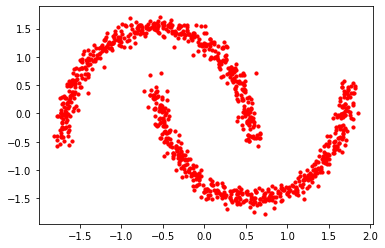

In [2]:
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

batch_size = 100
n_samples = 1000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, y = noisy_moons
X = StandardScaler().fit_transform(X)
samples = torch.tensor(X).type(torch.float)
plt.scatter(samples[:, 0], samples[:, 1], s=10, color='red');

## Construct Flow

The samples from target distribution are often used as input to a network. Thus, we construct a flow from target density (train data) to source density (known density i.e., Gaussian distribution).

$$
q(x) \rightarrow p(z)
$$

Formula derivation:

$$
\begin{aligned}
p(z) &= q(x) \vert det \bigtriangledown_x T(x) \vert^{-1} \\
\prod_{i=1}^n p(z_i) &= \prod_{i=1}^n q(x_i) \vert det \bigtriangledown_x T(x_i) \vert^{-1} \\
\sum_{i=1}^n \log p(z_i) &= \sum_{i=1}^n \log q(x_i) - \log \vert det \bigtriangledown_x T(x_i) \vert  \\
\end{aligned} \tag{1}
$$

Maximizing likelihood:

$$
\sum_{i=1}^n \log q(x_i) = \sum_{i=1}^n \log p(z_i) + \log \vert det \bigtriangledown_x T(x_i) \vert  \tag{2}
$$

In [3]:
# Here some modern flows were implemented 
from nflows.base import FlowSequential
from nflows.realnvp import LinearMaskedCoupling
from nflows.bn import BatchNormFlow

In [4]:
class RealNVP(nn.Module):
    '''
    Construct flows from target density (train data) to source density (known density i.e., Gaussian distribution.)
    x indicates train data while z indicates source samples
    target density -> source density
              q(x) -> p(z)
    '''
    def __init__(self, n_blocks, input_size, hidden_size, n_hidden, source_density):
        super(RealNVP, self).__init__()
        
        bijectors = []
        mask = torch.arange(input_size).float() % 2
        for i in range(n_blocks):
            bijectors += [LinearMaskedCoupling(input_size, hidden_size, n_hidden, mask)]
            mask = 1 - mask
            bijectors += [BatchNormFlow(input_size)]

        self.bijectors = bijectors
        self.source_density = source_density
        self.flows = FlowSequential(*bijectors)

    def forward(self, x):
        '''
        T(x) = z
        '''
        zs, sum_log_abs_det_jacobians = self.flows(x)
        return zs, sum_log_abs_det_jacobians

    def inverse(self, z):
        '''
        T^{-1}(z) = x
        '''
        xs, sum_log_abs_det_jacobians = self.flows.inverse(z)
        return xs, sum_log_abs_det_jacobians

    def log_prob(self, x):
        '''
        \log q(x) = \log p(z) + log_abs_det_jacobian
        '''
        zs, sum_log_abs_det_jacobians = self.forward(x)
        return self.source_density.log_prob(zs[-1]) + sum_log_abs_det_jacobians

In [5]:
source_density = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
nf = RealNVP(n_blocks=4, input_size=2, hidden_size=4, n_hidden=4, source_density=source_density)

## Visualization (before training)

In [18]:
def plot_flows(outputs):
    '''
    outputs (list): list of tensors
    '''
    f, arr = plt.subplots(1, len(outputs), figsize=(4 * (len(outputs)), 4))

    X0 = outputs[0].detach().numpy()
    for i in range(len(outputs)):
        X1 = outputs[i].detach().numpy()
        idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
        arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')

        idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
        arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')

        idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
        arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')

        idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
        arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')

        arr[i].set_xlim([-10, 10])
        arr[i].set_ylim([-10, 10])

From train distribution (toy dataset) to known distribution

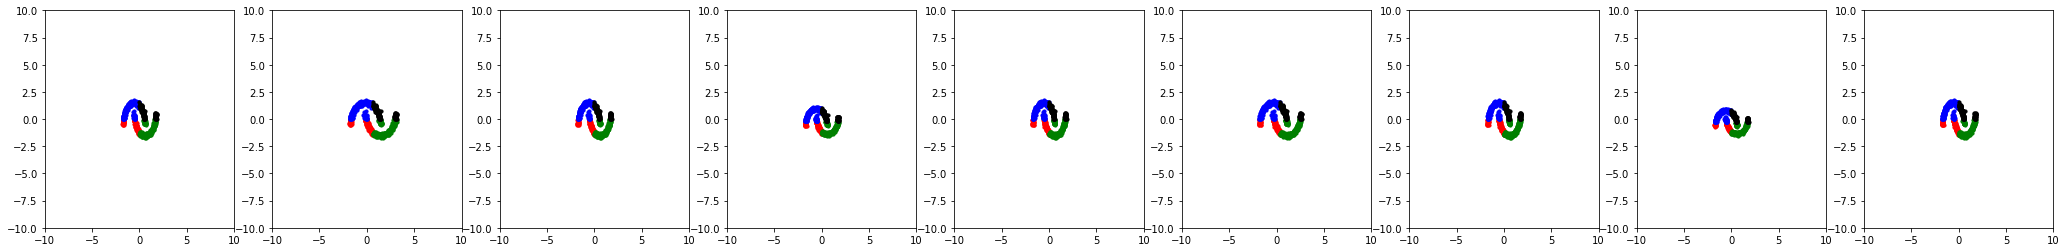

In [7]:
# train distribution -> known distribution
# q(x) -> p(z)
zs, _ = nf(samples)
plot_flows(zs)

## Optimize the Flow

In [8]:
optimizer = optim.Adam(nf.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99992)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[7000], gamma=0.1)

# Train
for it in range(20001):
    # samples of built toy distribution as train data
    loss = - nf.log_prob(samples).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if it % 1000 == 0:
        print(it, loss.item())

0 2.836702346801758
1000 1.5652360916137695
2000 1.4809139966964722
3000 1.4595249891281128
4000 1.4488996267318726
5000 1.439134120941162
6000 1.4302185773849487
7000 1.422683835029602
8000 1.418070912361145
9000 1.4084222316741943
10000 1.4055888652801514
11000 1.397570013999939
12000 1.397438406944275
13000 1.3884433507919312
14000 1.3889777660369873
15000 1.384753942489624
16000 1.3841701745986938
17000 1.3864004611968994
18000 1.382406234741211
19000 1.3819801807403564
20000 1.3818033933639526


## Visualization (after training)

train distribution $\rightarrow$ known distribution

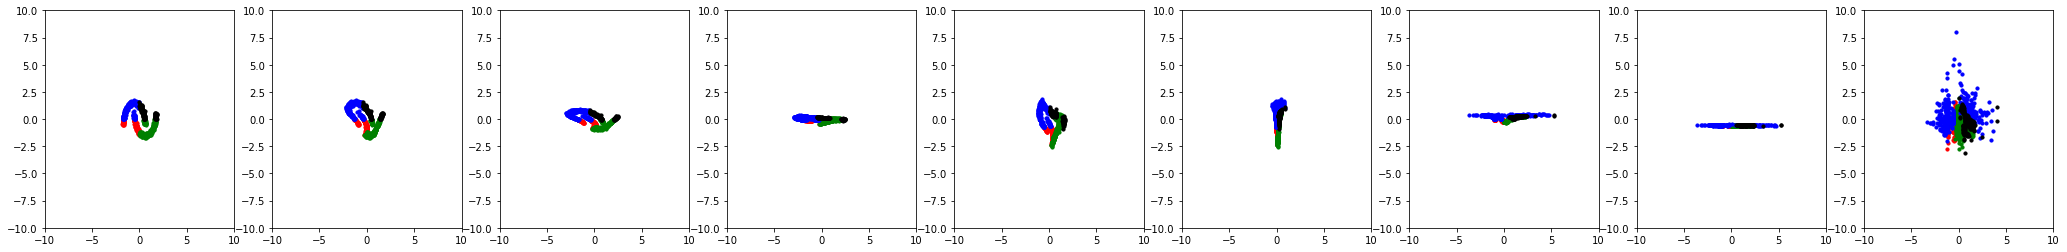

In [9]:
# train distribution -> known distribution
# q(x) -> p(z)
zs, _, = nf(samples)
plot_flows(zs)

 known distribution $\rightarrow$ train distribution

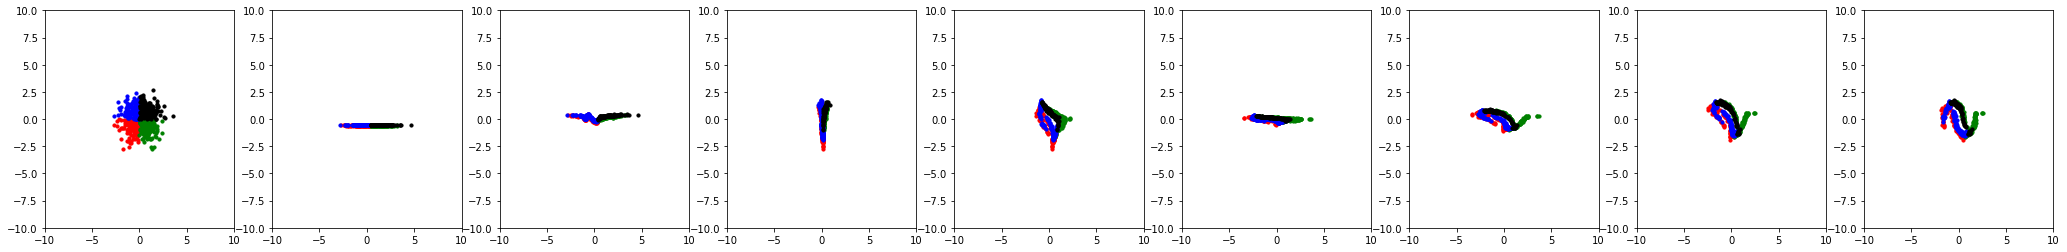

In [19]:
sources = source_density.sample((512, ))
xs, _, = nf.inverse(sources)
plot_flows(xs)

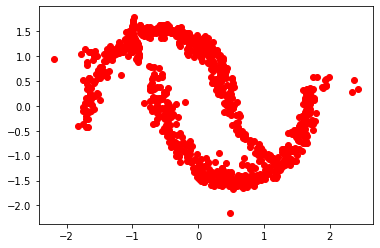

In [21]:
sources = source_density.sample((1000, ))
xs, _, = nf.inverse(sources)
tmp = xs[-1].detach().numpy()
plt.scatter(tmp[:, 0], tmp[:, 1], color='red');